<a href="https://colab.research.google.com/github/BrunooPorto/LaserWeeder-Inteligencia-artificial/blob/main/Prot%C3%B3tico_LaserWeeder_Inteligencia_artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Instalar bibliotecas necessárias
!pip install numpy pandas matplotlib tensorflow


Mounted at /content/drive


In [2]:
# Criar diretórios para organizar os dados
import os
if not os.path.exists('DeepWeeds'):
    os.makedirs('DeepWeeds')

In [3]:
# Criar pasta para armazenar o kaggle.json
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

In [4]:
# Ajustar permissões do arquivo aqui está o meu token
!chmod 600 ~/.kaggle/kaggle.json

# Baixar o DeepWeeds Dataset do Kaggle usei o token/api
!kaggle datasets download -d imsparsh/deepweeds

Dataset URL: https://www.kaggle.com/datasets/imsparsh/deepweeds
License(s): Attribution 4.0 International (CC BY 4.0)
100% 469M/470M [00:10<00:00, 38.2MB/s]
100% 470M/470M [00:10<00:00, 45.8MB/s]


In [5]:
# Criar diretório para o dataset e descompactar os arquivos
import os
import zipfile

if not os.path.exists('DeepWeeds'):
    os.makedirs('DeepWeeds')

with zipfile.ZipFile("/content/deepweeds.zip", 'r') as zip_ref:
    zip_ref.extractall("DeepWeeds")

print("Download e extração concluídos!")

Download e extração concluídos!


In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Diretório principal do dataset
dataset_dir = "DeepWeeds"

In [7]:
# Listar apenas os válidos
classes = [cls for cls in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, cls))]

# mostrar as classes disponíveis
print("Classes disponíveis:", classes)


Classes disponíveis: ['labels', 'images']


In [8]:
# Contar imagens por classe
for cls in classes:
    cls_dir = os.path.join(dataset_dir, cls)
    num_images = len(os.listdir(cls_dir)) if os.path.isdir(cls_dir) else 0
    print(f"{cls}: {num_images} imagens")


labels: 16 imagens
images: 17509 imagens


In [9]:
# Exibir algumas imagens de cada classe
for cls in classes[:3]:  # Exibir apenas 3 classes como exemplo
    cls_dir = os.path.join(dataset_dir, cls)
    valid_files = [f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

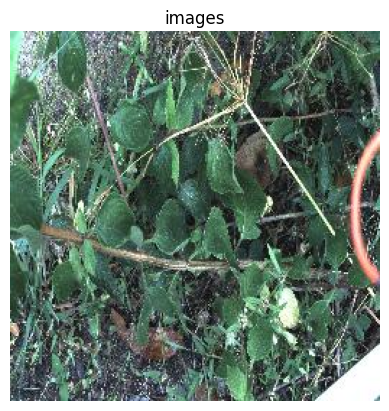

In [10]:
if valid_files:  # Garantir que há imagens válidas
        img_path = valid_files[0]
        img = Image.open(os.path.join(cls_dir, img_path))
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        plt.show()

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [12]:
def load_images_and_labels(dataset_dir, classes, img_size=(128, 128)):
    images = []
    labels = []
    # Iterar pelas classes e imagens
    for label, cls in enumerate(classes):
        cls_dir = os.path.join(dataset_dir, cls)
        valid_files = [f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]


        for img_file in valid_files:
            img_path = os.path.join(cls_dir, img_file)
            img = Image.open(img_path).resize(img_size)
            img = np.array(img)  # Converter para array numpy
            images.append(img)
            labels.append(label)  # A label é o índice da classe

    return images, labels

In [13]:
# Carregar imagens e labels
images, labels = load_images_and_labels(dataset_dir, classes)

In [14]:
import numpy as np

# dividir os dados em treino, validação e teste
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)

# dividir o treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# converter as listas de imagens para arrays NumPy
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# tratar as imagens (de [0, 255] para [0, 1])
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

In [15]:
#converter para vetores
y_train = to_categorical(y_train, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

In [16]:
# Criar geradores de imagem
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# Geradores de treino e validação
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

print("Dados preparados e prontos para treinamento!")

Dados preparados e prontos para treinamento!


In [18]:
import os
import random
import shutil

# Diretório principal do dataset
dataset_dir = "DeepWeeds"
base_dir = "DeepWeeds_split"

In [19]:
# Criar as pastas
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    for split in ["train", "val", "test"]:
        for cls in os.listdir(dataset_dir):
            cls_dir = os.path.join(base_dir, split, cls)
            os.makedirs(cls_dir, exist_ok=True)

In [20]:
# dividir os dados
def split_data(source_dir, dest_dir, split_ratios):
    classes = [cls for cls in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, cls))]
    for cls in classes:
        cls_dir = os.path.join(source_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(files)

        train_size = int(split_ratios[0] * len(files))
        val_size = int(split_ratios[1] * len(files))

        train_files = files[:train_size]
        val_files = files[train_size:train_size + val_size]
        test_files = files[train_size + val_size:]

        for file in train_files:
            shutil.copy(os.path.join(cls_dir, file), os.path.join(dest_dir, "train", cls))
        for file in val_files:
            shutil.copy(os.path.join(cls_dir, file), os.path.join(dest_dir, "val", cls))
        for file in test_files:
            shutil.copy(os.path.join(cls_dir, file), os.path.join(dest_dir, "test", cls))


In [21]:
# Dividir os dados: 70% treino, 15% validação, 15% teste (coloquei nesses valores.. testar outros dps)
split_data(dataset_dir, base_dir, split_ratios=(0.7, 0.15, 0.15))

print("Divisão dos dados concluída!")

Divisão dos dados concluída!


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# colocar o diretório base
base_dir = "DeepWeeds_split"

In [23]:
# config dos geradores de dados
#colocar parametros aleatorios para configurar leitura
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)  # configurar escala para normalizar


In [24]:
# generatorss para treino, validação e teste
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(224, 224),  # Redimensionar imagens
    batch_size=32,
    class_mode='categorical'  # classes
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 12256 images belonging to 2 classes.
Found 2626 images belonging to 2 classes.


In [25]:
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # para não embaralhar
)

print("Geradores configurados com sucesso!")

Found 2627 images belonging to 2 classes.
Geradores configurados com sucesso!


In [26]:
# Test do gerador de treino
import matplotlib.pyplot as plt

In [27]:
# catar as imagens e rótulos
images, labels = next(train_generator)

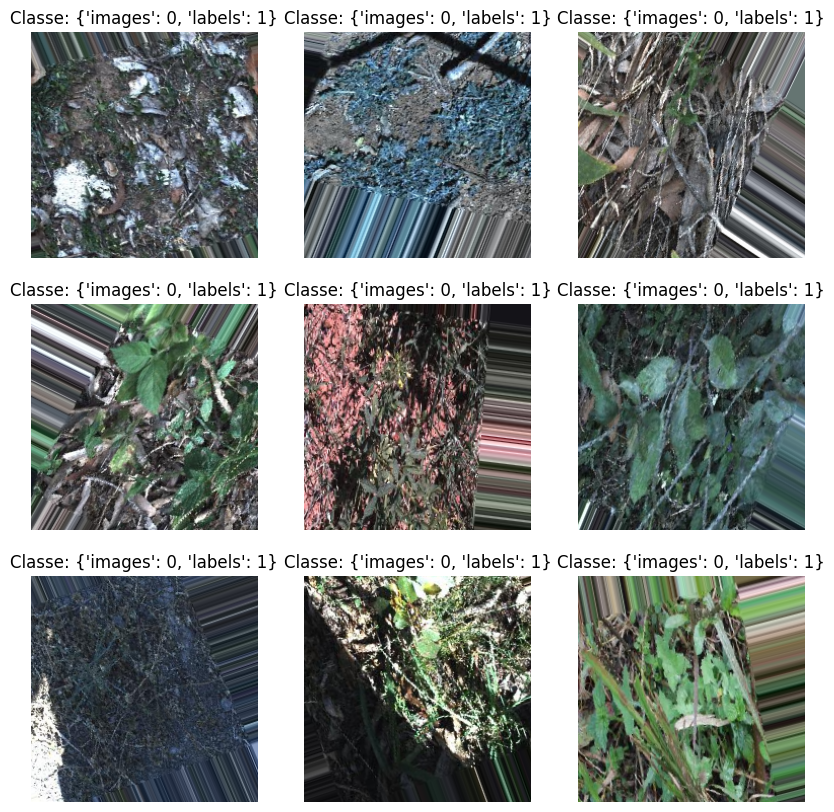

In [28]:
# mostrar exemplos de imagens
plt.figure(figsize=(10, 10))
for i in range(9):  # numero de imgens
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Classe: {train_generator.class_indices}")
    plt.axis('off')
plt.show()

In [29]:
#pegar o que precisamos
#https://keras.io/api/applications/mobilenet/
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

#esse demorou demais.. n sei pq

In [30]:
# Tentar carregar o MobileNetV2 (o v3 é em blocos, talvez n funcione)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
base_model.trainable = False

# Construir o modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduz a saída da base para um vetor de características
    layers.Dense(128, activation='relu'),  # Camada densa com 128 neurônios (geralmente dizem ser um bom numero)
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [32]:
# Compilar o modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
# vamo treinar o modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=6,  # Ajustar de acordo com o seu pc, senão pc explode kkk brincadeira
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)
#paciência aqui é onde mais demora, é o treino da sua IA
# Salvar o modelo
model.save("deepweeds_model.h5")

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


383/383 ━━━━━━━━━━━━━━━━━━━━ 953s 2s/step - accuracy: 0.9957 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/6


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 962s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 894s 2s/step - accuracy: 1.0000 - loss: 3.5020e-11 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [34]:
import matplotlib.pyplot as plt

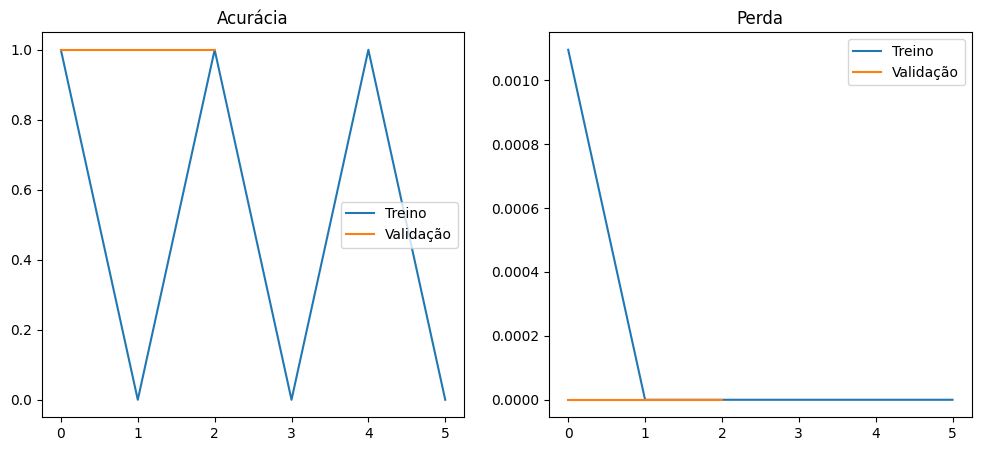

In [35]:
# para visualizar o desempenho
plt.figure(figsize=(12, 5))

# acurácia/precisão
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()

# perda/ erros
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda')
plt.legend()

plt.show()

In [36]:
# avaliar conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Perda no teste: {test_loss}")
print(f"Acurácia no teste: {test_accuracy}")


83/83 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
Perda no teste: 0.0
Acurácia no teste: 1.0


In [37]:
import numpy as np

# Fazer previsões no conjunto de teste
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Obter as classes previstas e reais
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Mostrar as primeiras 10 previsões
for i in range(10):
    print(f"Imagem {i + 1}")
    print(f"Classe verdadeira: {test_generator.class_indices}")
    print(f"Classe prevista: {predicted_classes[i]}")
    print()

83/83 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step
Imagem 1
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 2
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 3
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 4
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 5
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 6
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 7
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 8
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 9
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0

Imagem 10
Classe verdadeira: {'images': 0, 'labels': 1}
Classe prevista: 0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


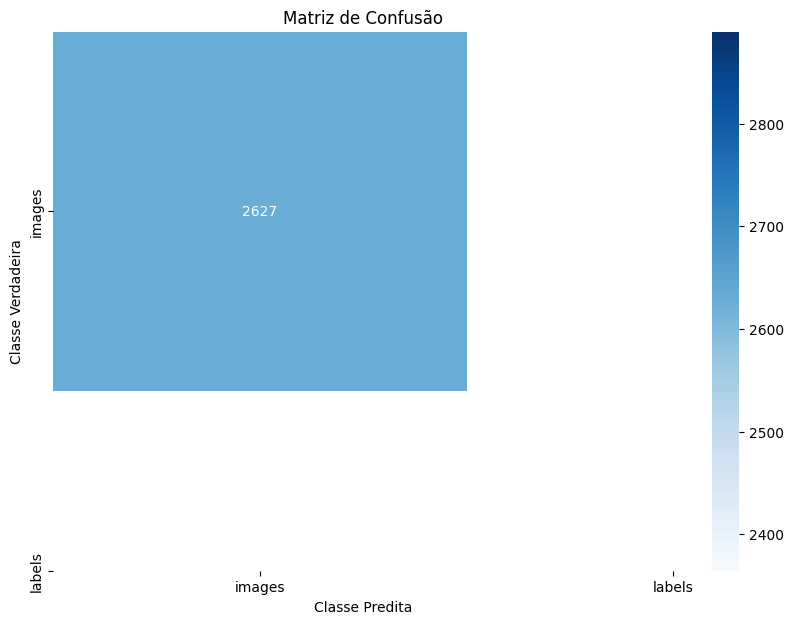

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obter a matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


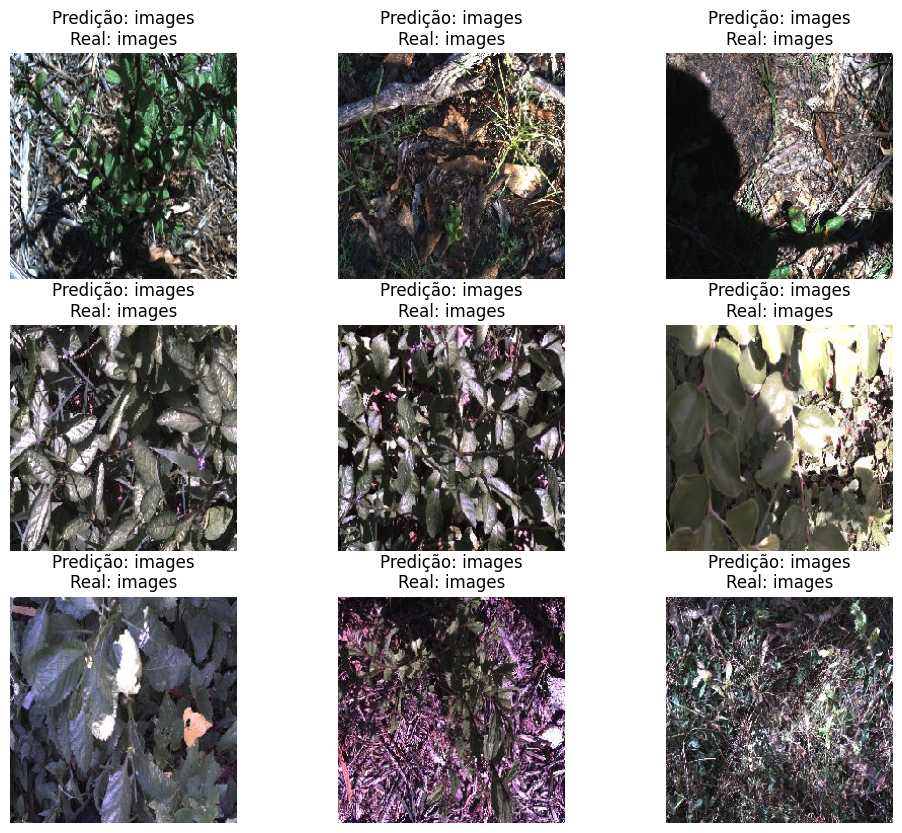

In [39]:
# Visualizando as previsões
plt.figure(figsize=(12, 10))
for i in range(9):  # Mostrar x imagens
    plt.subplot(3, 3, i + 1)

    # Obter uma imagem  do gerador
    img, label = test_generator[i]

    # Prever a classe da imagem
    pred = np.argmax(model.predict(img), axis=1)[0]  # Prever a classe para a imagem

    # Verificar se o label é one-hot encoded ou um índice
    if len(label.shape) > 1:  # esse é o erro que fica dando, corrigir ele e jogar para label 0
        label = np.argmax(label, axis=1)[0]

    # Mostrando a imagem
    plt.imshow(img[0])  # img[0] já é a imagem na forma correta

    # Obter o nome das classes
    predicted_class = list(test_generator.class_indices.keys())[pred]
    real_class = list(test_generator.class_indices.keys())[label]  # Usando o real class

    # Exibir o título
    plt.title(f"Predição: {predicted_class}\nReal: {real_class}")
    plt.axis('off')

plt.show()


In [40]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np

# Função para carregar uma imagem
def predict_image(uploaded_file):
    img = Image.open(uploaded_file['file'])
    img = img.resize((224, 224))  # Ajustar o tamanho para evitar erro no modelo
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Fazer a predição
    pred = np.argmax(model.predict(img_array), axis=1)[0]

    # Mostrar a imagem
    plt.imshow(img)
    plt.title(f"Predição: {list(test_generator.class_indices.keys())[pred]}")
    plt.axis('off')
    plt.show()

# Widget de upload de imagem
upload_widget = widgets.FileUpload(accept='.jpg,.png', multiple=False)
upload_widget.observe(lambda change: predict_image(change['new'][0]), names='value')

display(upload_widget)
#assim a pessoa pode subir uma imagem de planta e verificar o uso na hora, se é ou não uma weeder

FileUpload(value={}, accept='.jpg,.png', description='Upload')

83/83 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


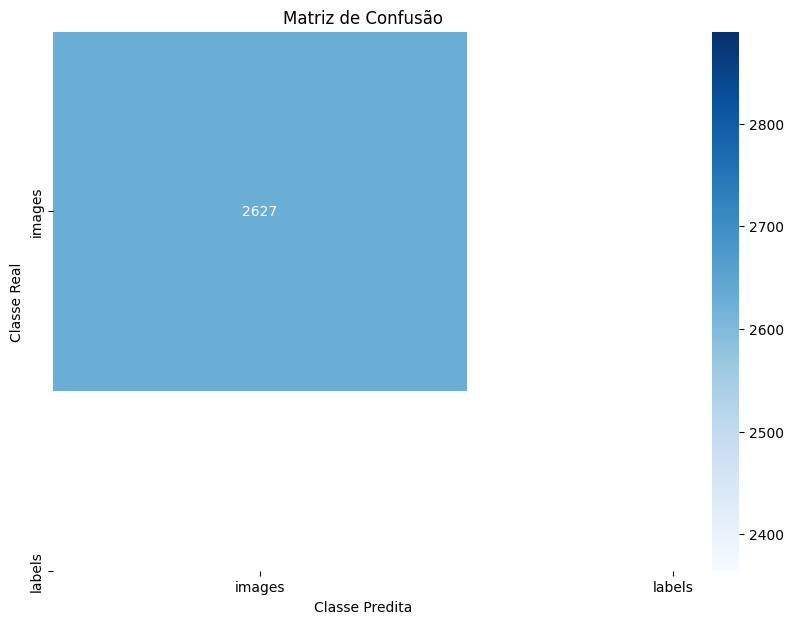

In [41]:
#novamente uma matriz d confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Previsões de teste
y_true = test_generator.classes
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# fazer o plot da matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()


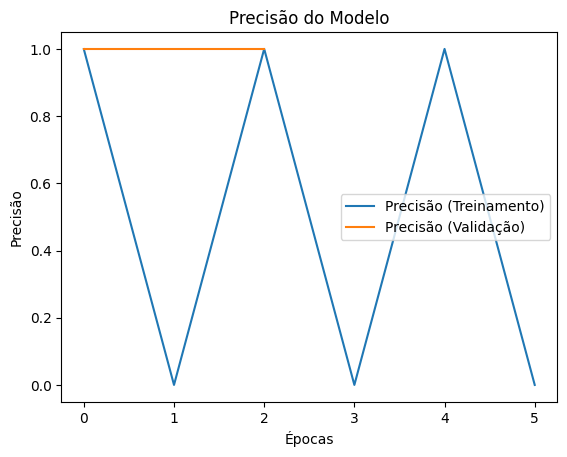

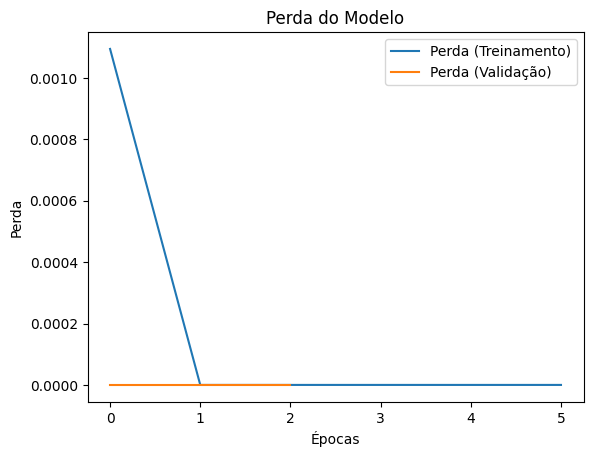

In [42]:
#mais gráficos para melhorar visualização

# Gráfico de precisão
plt.plot(history.history['accuracy'], label='Precisão (Treinamento)')
plt.plot(history.history['val_accuracy'], label='Precisão (Validação)')
plt.title('Precisão do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.show()

# Gráfico de perda
plt.plot(history.history['loss'], label='Perda (Treinamento)')
plt.plot(history.history['val_loss'], label='Perda (Validação)')
plt.title('Perda do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()


In [43]:
#salvar tudo agora e baixar para fazer os dashboards
# essa célula não é necessária caso não queira, é só para criar
# dashboards interativos no streamlit ou Power Bi
model.save("deepweeds_model.h5")
from google.colab import files
files.download("deepweeds_model.h5")  # Baixar o modelo para o computador


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
print(f"Tamanho de y_test: {len(y_test)}")
print(f"Tamanho de y_pred: {len(y_pred)}")


Tamanho de y_test: 3502
Tamanho de y_pred: 2627


In [57]:
#Isso garantirá que y_test e y_pred tenham o mesmo tamanho.

y_test = y_test[:len(y_pred)]
print(f"Tamanho ajustado de y_test: {len(y_test)}")
print(f"Tamanho de y_pred: {len(y_pred)}")

#Vamos também confirmar os tamanhos novamente:

Tamanho ajustado de y_test: 2627
Tamanho de y_pred: 2627


In [50]:
# Agora eles tem o mesmo tamanho
# vamos gerar predições completas
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Transformar probabilidades em classes


83/83 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step


In [51]:
# revalidar que y_test é gerado corretamente
# Obter rótulos reais
y_test = test_generator.classes


In [53]:
print("Classes únicas em y_pred:", np.unique(y_pred))
print("Classes únicas em y_test:", np.unique(y_test))
print("Nomes das classes em test_generator:", list(test_generator.class_indices.keys()))

#verificar se pegou as classes

Classes únicas em y_pred: [0]
Classes únicas em y_test: [0]
Nomes das classes em test_generator: ['images', 'labels']


In [54]:
labels = list(range(len(test_generator.class_indices)))
report = classification_report(
    y_test,
    y_pred,
    labels=labels,
    target_names=list(test_generator.class_indices.keys()),
    output_dict=True
)

#reajustar novamente, para pegar tudo possível

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

In [55]:
# Certicando de usar o gerador completo
predictions = model.predict(test_generator, verbose=1)

# Converter as probabilidades para classes
y_pred = np.argmax(predictions, axis=1)

print("Tamanho de y_pred:", len(y_pred))
print("Tamanho de y_test:", len(y_test))

#ajustando tamanhos

83/83 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step
Tamanho de y_pred: 2627
Tamanho de y_test: 2627


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

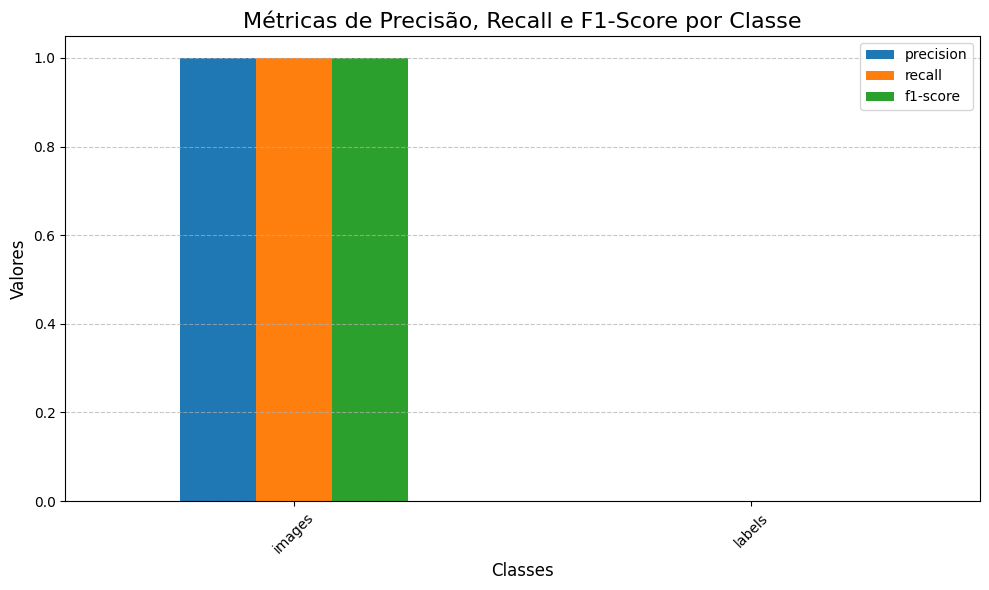

In [56]:
#começar a criar os dashboards dentro do colab

# Obter métricas detalhadas
report = classification_report(
    y_test,
    y_pred,
    labels=labels,
    target_names=list(test_generator.class_indices.keys()),
    output_dict=True
)

# Converter para DataFrame
metrics_df = pd.DataFrame(report).transpose()

# Plotar as métricas por classe
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df[:-3][['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax, rot=45)
plt.title("Métricas de Precisão, Recall e F1-Score por Classe", fontsize=16)
plt.ylabel("Valores", fontsize=12)
plt.xlabel("Classes", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Esse gráfico será um gráfico de barras comparando as métricas principais
# por classe, destacando os pontos fortes e fracos do modelo.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


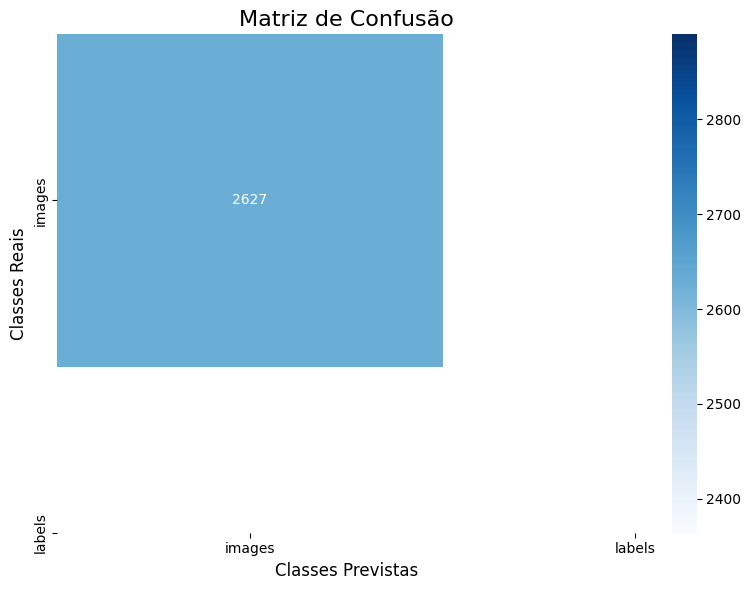

In [58]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), ax=ax)

plt.title("Matriz de Confusão", fontsize=16)
plt.ylabel("Classes Reais", fontsize=12)
plt.xlabel("Classes Previstas", fontsize=12)
plt.tight_layout()
plt.show()

#outra matriz de confusão, não deve ter alteração.. já que está dando 100% de acerto

In [60]:
# Salvar gráficos
fig.savefig("metrics_by_class.png")  # Salva o gráfico de métricas
fig.savefig("confusion_matrix.png")  # Salva a matriz de confusão